# Inventory Monitoring at Distribution Centers
## Problem Statement
Manual Inventory Management requires a huge workforce, and it is also error prone. So, there is a need for an effective inventory management.
Effective Inventory Management enables the business to save time and increase productivity. The automation of this process would eliminate the manual errors, thus saving cost and time. For larger organization, the process is much complicated.
With the recent advancement in the technology, we could solve the above problem with machine automated tasks. The Computer Vision Process aids us in solving the defined problem.
With the huge rise in the demand for inventory management, scalability is a major concerned that affects the long term run of the business. With the automated workflow, scalability becomes much simpler and cost efficient.
The solution can be replicated to different objects with respective datasets for training and the outcomes are measurable with the proposed evaluation metrics.
The problem is identified as a classification problem and upon given an input image from the live camera, the count of the objects in the bin can be predicted using the machine learning model.
This notebook walks through the solution of the identified problem.

We go over 3 primary steps : 

* Data Preparation step
    * Prepare images
    * upload to S3
* Training step
    * Hyperparameter Tuning
    * Train a best performance model and test it
    * Debugger and Profile Report
* Deploying step
    * deploy the model and test it

In [2]:
!pip install --upgrade pip
!pip install --upgrade sagemaker
!pip install --upgrade smdebug

In [3]:
import os
import boto3
import IPython
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, IntegerParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from smdebug.core.modes import ModeKeys
from smdebug.trials import create_trial
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from PIL import Image
import io
import json
from tqdm import tqdm

[2023-08-18 10:48:58.143 pytorch-2-0-0-cpu-py3-ml-t3-medium-11e14ffd7983b6f26dbcb1db6410:20002 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Data Preparation
The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [4]:
with open('file_list.json') as json_data:
    data = json.load(json_data)

count = dict()

for key, value in data.items():
    count[key] = len(value)

count

{'1': 1228, '2': 2299, '3': 2666, '4': 2373, '5': 1875}

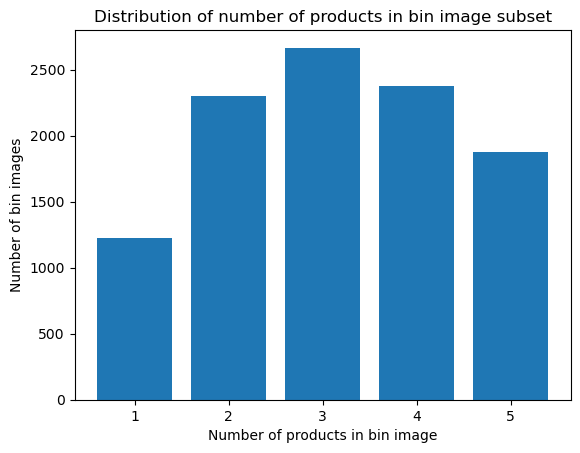

In [5]:
fig = plt.figure() 
plt.bar(count.keys(), count.values())
plt.xlabel('Number of products in bin image')
plt.ylabel('Number of bin images')
plt.title('Distribution of number of products in bin image subset')
fig.savefig('bin_image_dist.png') 

In [6]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))


In [7]:
download_and_arrange_data()

100%|██████████| 1228/1228 [01:56<00:00, 10.53it/s]


100%|██████████| 2299/2299 [03:41<00:00, 10.36it/s]


100%|██████████| 2666/2666 [04:13<00:00, 10.50it/s]


100%|██████████| 2373/2373 [03:48<00:00, 10.39it/s]


100%|██████████| 1875/1875 [02:58<00:00, 10.49it/s]


In [8]:
session = sagemaker.Session()
bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))
region = session.boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))
prefix = "project5/bin-images"

Default Bucket: sagemaker-us-east-1-640911352357
AWS Region: us-east-1
RoleArn: arn:aws:iam::640911352357:role/service-role/AmazonSageMaker-ExecutionRole-20230817T103804


In [9]:
inputs = session.upload_data(path="./train_data",
                             bucket=bucket, key_prefix=prefix)
print(f"input (S3 path): {inputs}")

input (S3 path): s3://sagemaker-us-east-1-640911352357/project5/bin-images


## Hyperparameter Tuning
It's time to finetune a pretrained model with hyperparameter tuning. The selected parameters are:

1. learning rate: for faster convergence
2. batch size: for faster training
3. epochs: for efficient training

`train.py` script is the one which be used for setting up hyperparameter tuning process.

In [10]:
list_models=["resnet34", "wide_resnet50_2",
             "resnet18", "resnet50", 
             "wide_resnet101_2", "resnet152",
             "resnext50_32x4d",  "resnet101",
             "resnext101_32x8d",
            ]

In [11]:
hyperparameter_ranges = {"lr" : ContinuousParameter(0.0000001,0.01),
                        "model-name" : CategoricalParameter(list_models),
                        "num-layers" : IntegerParameter(1,6),
                        "num-neurons": IntegerParameter(8,12)
                       }

objective_metric_name = "test accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "test accuracy", "Regex": "Test set: Accuracy: ([0-9\\.]+)"}]

In [25]:
estimator = PyTorch(
    entry_point="train.py",
    role=role,
    py_version='py310',
    framework_version="2.0",
    instance_count=2,
    instance_type="ml.g4dn.xlarge"
)

tuner = HyperparameterTuner(
    estimator = estimator,
    early_stopping_type = "Auto",
    metric_definitions = metric_definitions,
    objective_metric_name = objective_metric_name,
    objective_type = objective_type,
    max_jobs = 10,
    max_parallel_jobs = 1,
    hyperparameter_ranges = hyperparameter_ranges
)

In [13]:
os.environ["SM_CHANNEL_TRAIN"] = inputs
os.environ['SM_MODEL_DIR']="s3://"+ bucket+ "/project5/model/"
os.environ['SM_OUTPUT_DATA_DIR'] = "s3://"+ bucket+ "/project5/output/"

In [ ]:
tuner.fit({"train": inputs},wait=True) 

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [37]:
tuning_job_name = tuner.latest_tuning_job.job_name
tuning_job_name

'pytorch-training-230818-1310'

In [38]:
tuner = HyperparameterTuner.attach(tuning_job_name)

In [39]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-08-18 19:01:37 Starting - Found matching resource for reuse
2023-08-18 19:01:37 Downloading - Downloading input data
2023-08-18 19:01:37 Training - Training image download completed. Training in progress.
2023-08-18 19:01:37 Uploading - Uploading generated training model
2023-08-18 19:01:37 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"test accuracy"',
 'lr': '1.1141081219033358e-05',
 'model-name': '"resnext101_32x8d"',
 'num-layers': '2',
 'num-neurons': '11',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-08-18-13-10-50-459"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-640911352357/pytorch-training-2023-08-18-13-10-50-459/source/sourcedir.tar.gz"'}

In [40]:
tuner.analytics().dataframe()

,lr,model-name,num-layers,num-neurons,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,3.214914e-03,"""wide_resnet101_2""",4.0,11.0,pytorch-training-230818-1310-010-5a952982,Stopped,24.900000,2023-08-18 20:21:27+00:00,2023-08-18 20:55:07+00:00,2020.0
1,8.182657e-05,"""resnet152""",3.0,8.0,pytorch-training-230818-1310-009-0fdb304f,Completed,31.510000,2023-08-18 19:11:05+00:00,2023-08-18 20:13:03+00:00,3718.0
2,1.114108e-05,"""resnext101_32x8d""",2.0,11.0,pytorch-training-230818-1310-008-50f715fc,Completed,33.139999,2023-08-18 17:59:26+00:00,2023-08-18 19:01:35+00:00,3729.0
3,1.000000e-07,"""resnet34""",1.0,12.0,pytorch-training-230818-1310-007-ec376d7f,Stopped,24.709999,2023-08-18 17:41:59+00:00,2023-08-18 17:57:06+00:00,907.0
4,1.000000e-02,"""resnet50""",5.0,8.0,pytorch-training-230818-1310-006-7ebbbf8e,Stopped,25.379999,2023-08-18 17:22:30+00:00,2023-08-18 17:40:07+00:00,1057.0
5,8.280630e-06,"""resnet50""",3.0,8.0,pytorch-training-230818-1310-005-8001e745,Completed,31.610001,2023-08-18 16:23:12+00:00,2023-08-18 17:15:20+00:00,3128.0
6,2.611001e-06,"""resnext50_32x4d""",5.0,12.0,pytorch-training-230818-1310-004-440b9cb6,Stopped,24.709999,2023-08-18 16:00:25+00:00,2023-08-18 16:20:50+00:00,1225.0
7,2.324179e-05,"""resnet50""",1.0,8.0,pytorch-training-230818-1310-003-b594df8c,Completed,31.990000,2023-08-18 15:30:51+00:00,2023-08-18 15:57:16+00:00,1585.0
8,4.329413e-03,"""wide_resnet101_2""",5.0,9.0,pytorch-training-230818-1310-002-ea77511c,Completed,25.290001,2023-08-18 15:01:22+00:00,2023-08-18 15:30:03+00:00,1721.0
9,1.269162e-07,"""resnet152""",1.0,12.0,pytorch-training-230818-1310-001-2b732559,Completed,25.190001,2023-08-18 13:12:20+00:00,2023-08-18 15:00:54+00:00,6514.0


In [41]:
hyperparameters={key:eval(val) for key, val in best_estimator.hyperparameters().items() if key in hyperparameter_ranges}

## Model Profiling and Debugging

Having the best hyperparameter values in hand, we can train the model. We also enable debugger and profiler to monitor the trainig process. We use `train_model.py` for handling the training phase of our classification task.

In [70]:
hyperparameters["do-hook"]=True

In [71]:
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [83]:
estimator = PyTorch(
    role=role,
    instance_count=2,
    instance_type="ml.g4dn.xlarge",
    entry_point="train.py",
    framework_version="2.0",
    py_version="py310",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [ ]:
estimator.fit({"train": inputs},wait=True) 

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-08-19-02-00-55-717


Using provided s3_resource
2023-08-19 02:00:56 Starting - Starting the training job...
2023-08-19 02:01:11 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2023-08-19 02:02:51 Downloading - Downloading input data......
2023-08-19 02:03:52 Training - Downloading the training image........................
2023-08-19 02:07:53 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-08-19 02:07:51,400 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-08-19 02:07:51,418 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-08-19 02:07:51,428 sagemaker_pytorch_container.training

In [ ]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [ ]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-08-19 03:23:02.685 pytorch-2-0-0-cpu-py3-ml-t3-medium-11e14ffd7983b6f26dbcb1db6410:20002 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-640911352357/pytorch-training-2023-08-19-02-00-55-717/debug-output


In [ ]:
trial.tensor_names()

[2023-08-19 03:23:03.679 pytorch-2-0-0-cpu-py3-ml-t3-medium-11e14ffd7983b6f26dbcb1db6410:20002 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-08-19 03:23:04.702 pytorch-2-0-0-cpu-py3-ml-t3-medium-11e14ffd7983b6f26dbcb1db6410:20002 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/DataParallel_module.fc.0.bias',
 'gradient/DataParallel_module.fc.0.weight',
 'gradient/DataParallel_module.fc.2.bias',
 'gradient/DataParallel_module.fc.2.weight',
 'gradient/DataParallel_module.fc.4.bias',
 'gradient/DataParallel_module.fc.4.weight',
 'gradient/DataParallel_module.fc.6.bias',
 'gradient/DataParallel_module.fc.6.weight',
 'gradient/DataParallel_module.fc.8.bias',
 'gradient/DataParallel_module.fc.8.weight',
 'module.layer1.0.relu_input_0',
 'module.layer1.0.relu_input_1',
 'module.layer1.0.relu_input_2',
 'module.layer1.1.relu_input_0',
 'module.layer1.1.relu_input_1',
 'module.layer1.1.relu_input_2',
 'module.layer1.2.relu_input_0',
 'module.layer1.2.relu_input_1',
 'module.layer1.2.relu_input_2',
 'module.layer2.0.relu_input_0',
 'module.layer2.0.relu_input_1',
 'module.layer2.0.relu_input_2',
 'module.layer2.1.relu_input_0',
 'module.layer2.1.relu_input_1',
 'module.layer2.1.relu_input_2',
 'module.layer2.2.relu_input_0',
 '

In [ ]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

8

In [ ]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

1

In [ ]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [ ]:
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    fig.savefig(tensor_name+'.png') 
    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


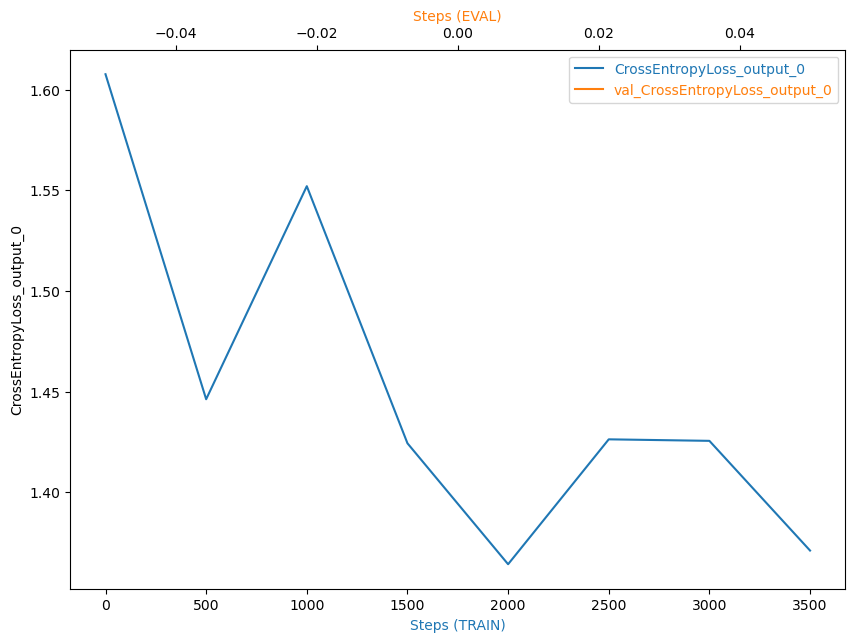

In [ ]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [ ]:
tj = TrainingJob(job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-640911352357/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-640911352357/pytorch-training-2023-08-19-02-00-55-717/profiler-output


Profiler data from system is available


In [ ]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-640911352357/pytorch-training-2023-08-19-02-00-55-717/rule-output


In [ ]:
! aws s3 ls {rule_output_path} --recursive

2023-08-19 03:21:12     455021 pytorch-training-2023-08-19-02-00-55-717/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-08-19 03:21:11     316970 pytorch-training-2023-08-19-02-00-55-717/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-08-19 03:21:05        549 pytorch-training-2023-08-19-02-00-55-717/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-08-19 03:21:05      71933 pytorch-training-2023-08-19-02-00-55-717/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-08-19 03:21:05        126 pytorch-training-2023-08-19-02-00-55-717/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-08-19 03:21:05        495 pytorch-training-2023-08-19-02-00-55-717/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-08-19 03:21:05      32180 pytorch-training-2023-08-19-02-00-55-717/rule-output/ProfilerReport/profiler-output/profiler-re

In [ ]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-640911352357/pytorch-training-2023-08-19-02-00-55-717/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-640911352357/pytorch-training-2023-08-19-02-00-55-717/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-640911352357/pytorch-training-2023-08-19-02-00-55-717/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-640911352357/pytorch-training-2023-08-19-02-00-55-717/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-640911352357/pytorch-training-2023-08-19-02

In [ ]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-640911352357/pytorch-training-2023-08-19-02-00-55-717/output/model.tar.gz


In [ ]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [ ]:
hyper = dict()

hyper["layers"] = 2**hyperparameters["num-layers"]*[2**hyperparameters["num-neurons"],]

hyper["model_name"] = hyperparameters["model-name"]

hyper["num_classes"] = 5

with open("inference_template.py","r") as f:
    raws=f.readlines()

i=raws.index("JPEG_CONTENT_TYPE = 'image/jpeg'\n")

ch="hyperparameters={}\n".format(str(hyper))

raws.insert(i+2,ch)
    
with open("inference.py","w") as f:
    f.writelines(raws)

In [ ]:
pytorch_model = PyTorchModel(
    model_data=model_data, 
    role=role, 
    entry_point='inference.py',
    py_version="py36",
    framework_version="1.8",
    predictor_cls=ImagePredictor
)


In [ ]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large') 

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-640911352357/pytorch-training-2023-08-19-02-00-55-717/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-640911352357/pytorch-inference-2023-08-19-03-23-10-479/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-08-19-03-23-55-172
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-08-19-03-23-55-993
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-08-19-03-23-55-993


-----!

In [ ]:
with open("./train_data/4/00099.jpg", "rb") as f:
    image = f.read() 

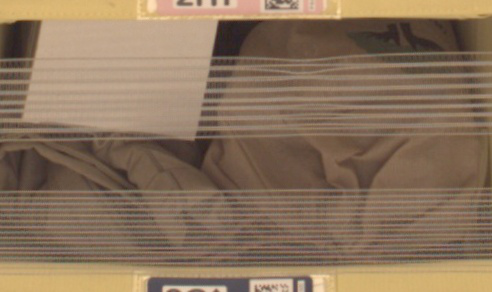

In [ ]:
Image.open(io.BytesIO(image))

In [ ]:
response = predictor.predict(image , initial_args={"ContentType": "image/jpeg"})

In [ ]:
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(1,6), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Raw prediction result:
[[-1.7202140092849731, -0.09610053151845932, 0.5768313407897949, 0.736311674118042, 0.5343678593635559]]

Labeled predictions: 
[(1, -1.7202140092849731), (2, -0.09610053151845932), (3, 0.5768313407897949), (4, 0.736311674118042), (5, 0.5343678593635559)]

Most likely answer: (4, 0.736311674118042)


In [ ]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-08-19-03-23-55-993
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-08-19-03-23-55-993
